<a href="https://colab.research.google.com/github/Tarleton-Math/data-science-20-21/blob/master/data_science_20_21_notes_10_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Intro to Naive Bayes and Imputation of Missing Data
## Class Notes 2020-10-06
## Data Science (masters)
## Math 5364 & 5366, Fall 20 & Spring 21
## Tarleton State University
## Dr. Scott Cook

In [1]:
! pip install --upgrade numpy
! pip install --upgrade pandas

     |████████████████████████████████| 14.5MB 308kB/s 
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5


     |████████████████████████████████| 9.5MB 2.7MB/s 
  Found existing installation: pandas 1.1.2
    Uninstalling pandas-1.1.2:
      Successfully uninstalled pandas-1.1.2


Today we meet new
- Dataset called [HouseVotes84](https://archive.ics.uci.edu/ml/datasets/congressional+voting+records)
    - voting records of 435 the member of the US House of Representatives on 16 important bills in 1984
    - Goal - predict party affiliation from the voting record.
- Preprocessing - [Imputing missing data](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.impute)
    - Datasets often have holes where data is missing.  These can cause significant problems for machine learners, so we need to impute (fill) these holes in a reasonable way we could defend to a skeptic.
    - [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer) offers many useful simple imputation strategies.
    - [KNNImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html#sklearn.impute.KNNImputer) imputes missing values based on the mean value of that feature for the $k$ nearest observations.  This is a more recent strategy that has become quite popular.
- Classifier - [Naive Bayes Classifier](https://scikit-learn.org/stable/modules/naive_bayes.html)
    - We'll focus on the [Bernoulli Naive Bayes Classifier](https://scikit-learn.org/stable/modules/naive_bayes.html#bernoulli-naive-bayes), which is designed for boolean features.
    - Another variant is [Multinomial Naive Bayes Classifier](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes), designed for discrete features that count the occurences certain events, patterns, samples, etc such as word counts in text.
    - Another variant is [Gaussian Naive Bayes Classifier](https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes), which is designed for continuous features that have approximately normal distributions with each target class.  $P(x_i|y) \sim N(\mu_{iy}, \sigma_{iy})$

## Mathematical Background for Naive Bayes

Let $X$ be a random variable and $x$ be one of its possible values.

- $P(X=x)$ denotes the probability of the set of outcomes (event) where $X=x$.  As shorthand, we'll simply write $P(x)$
- $P(X=x \cap Y=y)$ denotes the probability of the set of outcomes (event) where $X=x$ and $Y=y$.  As shorthand, we'll simply write $P(x,y)$.
    - Note that $P(x,y) = P(y,x)$
        - Pf: $P(x,y)=P(X=x \cap Y=y)=P(Y=y \cap X=x) = P(y,x)$
- $P(X=x | Y=y)$ denotes the conditional probability of the set of outcomes (event) where $X=x$ given that $Y=y$.  As shorthand, we'll simply write $P(x|y)$.
    - The difference between $P(x|y)$ and $P(x,y)$ is whether $y$ has already occured.  $P(x|y)$ is the proportion of times when $y$ has already occurred (or is certain to occur) that $x$ also happens.
    - Thus, we have Thomas Bayes famous formula
    $$P(x|y) = \frac{P(x,y)}{P(y)}$$ or alternately $$P(x,y) = P(x|y)P(y)$$
    - We also have
    $$P(x|y)P(y) = P(y|x)P(x)$$
        - Pf: $P(x|y)P(y) = P(x,y) = P(y,x) = P(y|x)P(x)$
    - We can chain Bayes Formula to get
    $$P(x_1,x_2,y) = P(x_1|x_2,y)P(x_2,y) = P(x_1|x_2,y)P(x_2|y)P(y)$$
Note we're simply picking the expression apart one variable at a time.  Continuing this pattern, we can get
$$P(x_1,x_2,x_3\dots,x_d,y) = P(x_1|x_2,x_3,\dots,x_d,y)P(x_2|x_3,\dots,x_d,y)P(x_3|\dots,x_d,y) \cdots P(x_d|y)P(y)$$

- The "naive" part of "Naive Bayes" is the assumption
$$P(x_i|x_{i+1},x_{i+2},\dots,x_d,y) = P(x_i|y)$$
which essentially says that any conditional dependence between the $x's$ is fully "explained" by $y$.
    - In the HouseVotes84 example, this naive assumption says that, if you want to predict Charlie's vote on bill $i$ and you already know Charlie is a democratic, your predicition will NOT get more accurate if you discover how he voted on the other bills.
    - Obviously, this is wrong (naive).  But, the method often still works very well.
    - We make this naive assumption because we rarely have enough data to directly estimate $P(x_1,x_2,x_3\dots,x_d,y)$ or $P(x_i|x_{i+1},x_{i+2},\dots,x_d,y).$
    - This assumption effectively erases all $x$ from the right of the |.
    - There is a less naive version called "Bayesian Belief Networks", which we won't have time for in this class.



## Naive Bayes
Using the facts above and the "naive" assumption, we derive the formula for each entry of the the "predict_proba" vector.

$P(y|x_1,x_2,\dots,x_d) = \frac{P(x_1,x_2,\dots,x_d,y)}{P(x_1,x_2,\dots,x_d)}$

This is the basic form of Bayes Theorem.  Because the denominator will just go along for the ride, let's make this easier on the eyes by defining $a = 1/P(x_1,x_2,\dots,x_d)$

$P(y|x_1,x_2,\dots,x_d) = a P(x_1,x_2,\dots,x_d,y)$

$ = a P(x_1|x_2,x_3,\dots,x_d,y)P(x_2|x_3,\dots,x_d,y) \cdots P(x_d|y)P(y)$

$ = a P(x_1|y)P(x_2|y)P(x_3|y) \cdots P(x_d|y)P(y)$

So, the final NB expression is:
$$P(y|x_1,x_2,\dots,x_d) = a P(x_1|y)P(x_2|y)P(x_3|y) \cdots P(x_d|y)P(y)$$

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix

# Column names (bills in the 1984 congressional session)
columns = ['party', 'handicapped-infants', 'water-project-cost-sharing',
           'adoption-of-the-budget-resolution', 'physician-fee-freeze',
           'el-salvador-aid', 'religious-groups-in-schools',
           'anti-satellite-test-ban', 'aid-to-nicaraguan-contras', 'mx-missile',
           'immigration', 'synfuels-corporation-cutback', 'education-spending',
           'superfund-right-to-sue', 'crime', 'duty-free-exports',
           'export-administration-act-south-africa']

# Observe that we can pull this dataset directly from the web - no need for a local copy
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data',
                 header=None, names=columns)

# Target = party (column 0)
# Features = 16 votes (columns >=1)
X, y = data.iloc[:,1:].copy(), data.iloc[:,0].copy()

# Replace 'y'→True, 'n'→False, '?'→NaN
X[X=='y'] = True
X[X=='n'] = False
X[X=='?'] = np.nan

# There are some member of congress that missed all/almost all votes.
# We'll exclude any that missed 10 or more (of 16)
print(X.shape)
mask = X.isnull().sum(axis=1) <= 10
X, y = X[mask], y[mask]
print(X.shape)
n, d = X.shape

# holdout/model split
holdout_frac = 0.15
holdout_splitter = StratifiedShuffleSplit(n_splits=1, test_size=holdout_frac, random_state=42)
model_idx, holdout_idx = next(holdout_splitter.split(X, y))
X_m, y_m = X.iloc[model_idx]  , y.iloc[model_idx]
X_h, y_h = X.iloc[holdout_idx], y.iloc[holdout_idx]
X_m.shape, X_h.shape

def display_results(grid, cutoff=1.0):
    res = grid.cv_results_
    df = pd.DataFrame(res['params'])
    df['score'] = (res['mean_test_score'] * 100)
    mask = df['score'] >= df['score'].max() * min(1-cutoff, 1)
    with pd.option_context('display.max_rows', 100, 'precision', 2):
        display(df[mask].sort_values('score', ascending=False))
    return df

def display_confusion_matrix(y_true, y_pred):
    """Pretty display for confusion matrix"""
    labels = y_true.unique()
    cf = confusion_matrix(y_true, y_pred, labels)
    acc = cf.trace() / cf.sum() * 100
    df = pd.DataFrame(cf, columns=labels, index=labels)
    df.index.name = 'Actual'
    df.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    plt.title(f'accuracy={acc:.2f}%')
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
    plt.show()

    idx = y_true != y_pred
    df_errors = pd.DataFrame()
    df_errors['y_true'] = y_true[idx]
    df_errors['y_pred'] = y_pred[idx]
    display(df_errors)
    return df

(435, 16)
(432, 16)


To start, let's just try to apply BernoulliNB directly.

In [ ]:
classify = BernoulliNB()
classify.fit(X_m, y_m)

ValueError: ignored

The missing values screw up NB.  So, we need to impute values before using it.  First, create 2 convenience functions.

In [ ]:
def display_df(df, highlight_cells=None):
    """Display df with formatting and highlight specified cells"""
    highlight = df.copy()
    highlight[:] = None
    if highlight_cells is not None:
        highlight[highlight_cells] = 'background-color: green'
    display(df.style
        .apply(lambda z: highlight, axis=None)
        .set_precision(2)
        .set_properties(**{'text-align':'center', 'border-width':'thin','border-style':'solid'})
        .set_table_attributes('style="border-collapse:collapse"')
        )

from sklearn.exceptions import NotFittedError
def my_impute(X, imputer):
    """Fits imputer if needed, transforms X, reattachs column and index names, prints most frequently imputed rows"""
    X_imp = X.copy()
    try:
        X_imp[:] = imputer.transform(X)
    except NotFittedError:
        imputer.fit(X)
        X_imp[:] = imputer.transform(X)
    
    display_rows = 10
    mask = X.isnull()  # marks all NaN cells
    idx = mask.sum(axis=1).argsort()[:-display_rows:-1]  # get idx of display_rows rows with most NaN's
    display_df(X_imp.iloc[idx], highlight_cells=mask.iloc[idx])  # display new df, highlight imputed cells
    return X_imp

In [ ]:
my_impute(X_m, SimpleImputer(strategy='most_frequent'));

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
129,False,True,True,False,False,False,True,True,False,False,False,False,False,True,False,True
377,False,True,False,True,True,True,True,True,False,False,False,False,True,True,False,True
180,False,True,True,False,False,False,True,True,True,False,False,False,False,False,False,True
104,False,True,True,False,False,True,True,True,True,True,False,False,True,True,False,True
390,False,True,False,False,True,True,True,False,False,False,True,True,False,True,False,True
115,False,True,True,False,True,True,True,True,True,True,False,False,False,False,True,True
400,False,True,False,True,True,True,False,True,False,False,False,False,False,True,False,True
341,False,True,True,False,False,True,True,True,True,True,True,False,False,True,True,True
157,False,True,True,False,False,True,False,True,True,False,True,False,False,True,False,True


The highlighted cells were inputed using the most frequent value in the same columns.  See [this](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer) for other available simple imputations strategies.

In [ ]:
X_m.describe()

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
count,359,327,361,361,357,360,360,358,350,365,351,346,350,356,346,280
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,False,True,True,False,True,True,True,True,True,False,False,False,True,True,False,True
freq,195,168,213,210,180,226,203,208,175,185,222,199,175,213,194,225


So, let's make a pipeline and see that error is gone.

In [ ]:
pipe = Pipeline([('impute', SimpleImputer(strategy='most_frequent')),
                 ('classify', BernoulliNB())])
pipe.fit(X_m, y_m)

Pipeline(memory=None,
         steps=[('impute',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='most_frequent',
                               verbose=0)),
                ('classify',
                 BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None,
                             fit_prior=True))],
         verbose=False)

Great!!  Now, back to supervised learning.

Though it is overkill, let's get in the habit of using the [hyper-parameter optimizers](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection) to make tuning and cross-validation easy and automatic.

In [ ]:
pipe = Pipeline([('impute', SimpleImputer(strategy='most_frequent')),
                 ('classify', BernoulliNB())])
hyperparams = {}
grid = GridSearchCV(pipe, hyperparams, cv=10, scoring='accuracy').fit(X_m, y_m)
display_results(grid);

,score
0,90.47


Great!  Now, this simple imputer has a conceptual flaw.  It assigns the same fill value to ALL missing values in a column, regardless of the target class (dem/rep) of that row.  Don't you think we should impute differently depending on which party that congressperson belongs to?

One idea is to impute based on the most frequent vote along all members of the same party (ignoring the other party).

That's a good idea, but the code to do it is a little involved (though certainly doable).  Also, that induces some circularity.  We're tyring to predict party affiliation.  We probably shouldn't be USING the thing we're trying to predict within the predictor.  That's cheating (but it is still done occasionally because its not especially egregious).

Instead, let's impute using the $k$ neareast neighbors based on only the features $X$ (not targets $y$)
- Suppose X[i,j] is missing
- Ignoring row $i$ and column $j$, let idx be the $k$ rows that are closest to row $i$
- Impute X[i,j]= X.iloc[idx, j].mean()


In [ ]:
my_impute(X_m, KNNImputer(n_neighbors=5));

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
129,1.00,0.20,1.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.80,1.00
377,0.00,1.00,0.00,1.00,1.00,1.00,0.20,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.20,0.40
180,0.80,0.80,1.00,0.00,0.00,0.00,1.00,1.00,1.00,0.40,0.40,0.00,0.00,0.00,0.40,1.00
104,0.60,0.60,0.80,0.00,0.00,1.00,1.00,1.00,1.00,1.00,0.60,0.00,1.00,1.00,0.00,1.00
390,0.20,0.60,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,0.80
115,0.00,0.20,1.00,0.00,0.00,0.20,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00
400,0.00,1.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.80
341,0.00,0.20,1.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.20,1.00,1.00
157,0.00,1.00,1.00,0.00,0.00,1.00,0.00,1.00,1.00,0.00,1.00,0.00,0.60,0.40,0.80,1.00


That's great, except now the entries aren't boolean T/F.  No problem ... BernoulliNB will convert to boolean via the hyperparameter called "binarize".  Any value greater than "binarize" becomes True while any less than "binarize" becomes false.  So, let's use GridSearchCV to optimize:
 this threshhold.
 - binarize
 - n_neighbors

In [ ]:
%%time
pipe = Pipeline([('impute', KNNImputer()),
                 ('classify', BernoulliNB())])
hyperparams = {'impute__n_neighbors' : np.arange(1, 10),
               'classify__binarize': np.linspace(0, 1, 5)}
grid = GridSearchCV(pipe, hyperparams, cv=10, scoring='accuracy').fit(X_m, y_m)
display_results(grid, cutoff=0.1);

,classify__binarize,impute__n_neighbors,score
1,0.00,2,90.74
10,0.25,2,90.74
11,0.25,3,90.47
2,0.00,3,90.47
13,0.25,5,90.47
12,0.25,4,90.20
22,0.50,5,90.20
20,0.50,3,90.20
25,0.50,8,90.20
26,0.50,9,90.20


CPU times: user 9.78 s, sys: 7.1 s, total: 16.9 s
Wall time: 8.54 s


Shifting from the coarse SimpleImputer(strategy='most_frequent') to the more refined KNNImputer helped a little.

Let's go [here](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html) and [here](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html) to look for other hyperparameters to tune.

Here's some background on [Laplace smoothing](https://en.wikipedia.org/wiki/Additive_smoothing).

In [ ]:
%%time
pipe = Pipeline([('impute', KNNImputer()),
                 ('classify', BernoulliNB())])
hyperparams = {'impute__n_neighbors' : np.arange(1, 10),
               'impute__weights': ['uniform', 'distance'],
               'classify__binarize': np.linspace(0, 1, 10),
               'classify__alpha': np.linspace(0.01, 2, 10)}
grid = GridSearchCV(pipe, hyperparams, cv=10, scoring='accuracy').fit(X_m, y_m)
display_results(grid, cutoff=0.01);

,classify__alpha,classify__binarize,impute__n_neighbors,impute__weights,score
1496,1.78,0.33,2,uniform,90.74
956,1.12,0.33,2,uniform,90.74
1514,1.78,0.44,2,uniform,90.74
1136,1.34,0.33,2,uniform,90.74
1316,1.56,0.33,2,uniform,90.74
...,...,...,...,...,...
1011,1.12,0.67,2,distance,89.92
1010,1.12,0.67,2,uniform,89.92
1009,1.12,0.67,1,distance,89.92
1008,1.12,0.67,1,uniform,89.92


CPU times: user 6min 38s, sys: 4min 54s, total: 11min 33s
Wall time: 5min 52s


Well, that didn't help.  Maybe this is the best we can do with Naive Bayes.  Let's test its generalization performance on the holdout set.  Recall that GridSearchCV automatically helps us by
- Selecting a "best" model (its tie-breaking rules are unclear to me)
- Fitting that model on the entire modeling dataset

So, grid.predict work and applies this refit best model!  Cool!

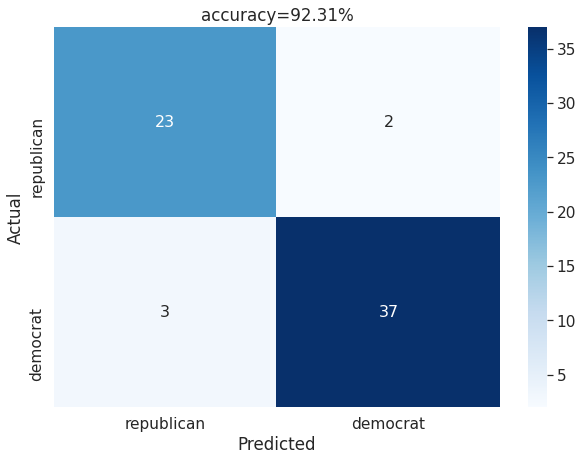

,y_true,y_pred
393,republican,democrat
384,democrat,republican
372,democrat,republican
402,republican,democrat
394,democrat,republican


In [ ]:
y_pred = grid.predict(X_h)
display_confusion_matrix(y_h, y_pred);

## By hand calculations
We can actually do a decent chunk of this without relying on the sci-kit learn BernoulliNB function.

Recall the NB formula above

$$P(y|x_1,x_2,\dots,x_d) = a P(x_1|y)P(x_2|y)P(x_3|y) \cdots P(x_d|y)P(y)$$

Let's write this by hand using the SimpleImputer.

In [ ]:
imputer = SimpleImputer(strategy='most_frequent').fit(X_m)
X_m_imp = my_impute(X_m, imputer)
X_h_imp = my_impute(X_h, imputer)

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
129,False,True,True,False,False,False,True,True,False,False,False,False,False,True,False,True
377,False,True,False,True,True,True,True,True,False,False,False,False,True,True,False,True
180,False,True,True,False,False,False,True,True,True,False,False,False,False,False,False,True
104,False,True,True,False,False,True,True,True,True,True,False,False,True,True,False,True
390,False,True,False,False,True,True,True,False,False,False,True,True,False,True,False,True
115,False,True,True,False,True,True,True,True,True,True,False,False,False,False,True,True
400,False,True,False,True,True,True,False,True,False,False,False,False,False,True,False,True
341,False,True,True,False,False,True,True,True,True,True,True,False,False,True,True,True
157,False,True,True,False,False,True,False,True,True,False,True,False,False,True,False,True


,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
295,False,True,False,True,True,True,True,True,False,True,False,True,False,True,False,True
261,True,False,True,False,False,True,True,True,True,False,False,False,False,True,False,True
393,False,True,True,False,False,True,False,True,True,False,False,True,True,False,False,True
95,True,False,True,False,True,True,False,True,False,False,True,False,False,True,True,True
433,False,False,False,True,True,True,True,True,False,False,False,True,True,True,False,True
413,True,True,True,True,True,True,True,True,False,True,False,False,False,True,False,True
394,True,True,True,False,True,True,False,False,False,False,True,False,True,False,False,True
170,True,False,True,False,False,False,True,True,True,False,False,False,False,False,True,True
247,False,True,False,True,True,True,True,False,False,False,False,False,True,True,False,False


party,democrat,republican
handicapped-infants,0.601770,0.198582
water-project-cost-sharing,0.566372,0.567376
adoption-of-the-budget-resolution,0.889381,0.127660
physician-fee-freeze,0.053097,0.985816
el-salvador-aid,0.243363,0.957447
religious-groups-in-schools,0.477876,0.886525
anti-satellite-test-ban,0.778761,0.241135
aid-to-nicaraguan-contras,0.845133,0.184397
mx-missile,0.703540,0.113475
immigration,0.460177,0.539007


democrat      0.615804
republican    0.384196
Name: party, dtype: float64

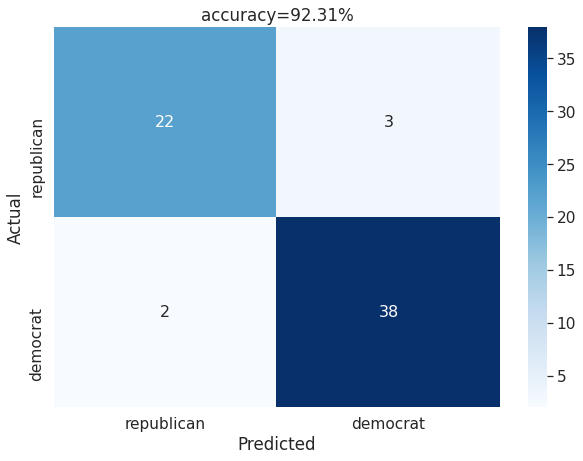

,y_true,y_pred
393,republican,democrat
384,democrat,republican
413,republican,democrat
372,democrat,republican
402,republican,democrat


In [ ]:
A = X_m_imp.astype(float).groupby(y_m).mean()  # groupbys by party and the compute the proportion of 'y' for each bill
display(A.T)  # Conditional probabilites P(x_i|y)
P_votes = {True:A, False:1-A}

P_party = y_m.value_counts(normalize=True)  # proportions of rep & dem; this is what P(y) stands for
display(P_party)

def my_NB(row):
    predict_proba = P_party.copy()  # We need to multiply by P(y) eventually, so let's just start with it
    for bill, vote in row.iteritems():
        predict_proba *= P_votes[vote][bill]
    predict_proba /= predict_proba.sum()
    predict = predict_proba.idxmax()
    return {'predict':predict, 'democrat':predict_proba['democrat'], 'republican':predict_proba['republican']}

y_pred = X_h_imp.apply(my_NB, axis=1, result_type='expand')
display_confusion_matrix(y_h, y_pred['predict']);